In [8]:
!pip install category_encoders

  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import requests
from urllib.parse import urlencode
# используем api yandex disk
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/jj6FG3ZFHdCWAQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

In [10]:
data = pd.read_csv('df_general.csv')

In [11]:
data

,match_id,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,team_1_hue,month,day_week,hour,ground_id,...,result_lag_4_team_1,result_lag_5_team_1,result_lag_1_team_2,result_lag_2_team_2,result_lag_3_team_2,result_lag_4_team_2,result_lag_5_team_2,game_lag_1,game_lag_2,game_lag_3
0,9611,1,2014,Arsenal,Crystal Palace,1,Aug,Sat,17,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9612,1,2014,Leicester City,Everton,2,Aug,Sat,15,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9613,1,2014,Manchester United,Swansea City,0,Aug,Sat,12,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9614,1,2014,Queens Park Rangers,Hull City,0,Aug,Sat,15,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9615,1,2014,Stoke City,Aston Villa,0,Aug,Sat,15,435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,93539,22,2023,Liverpool,Chelsea,1,Jan,Wed,20,901,...,2.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0
3368,93540,22,2023,Manchester City,Burnley,1,Jan,Wed,19,457,...,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
3369,93545,23,2023,Burnley,Fulham,2,Feb,Sat,15,47,...,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
3370,93547,23,2023,Everton,Tottenham Hotspur,2,Feb,Sat,12,31,...,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0


In [6]:
X = data.drop('team_1_hue', axis=1)
y = data['team_1_hue']

In [12]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_encoder', TargetEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_processed = pipeline.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [45]:
class CustomDataset_train(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return self.X_train.shape[0]

    def __getitem__(self, idx):
        r_i = self.y_train[idx]
        r_j = 0 if r_i == 1 else 1 if r_i == -1 else 0 # ранг второй команды - поражение, победа или ничья - определяется из ранга первой команды
        X_i = self.X_train[idx]
        X_j = self.X_train[idx]
        
        print(X_i, X_j, r_i, r_j)
        
        return X_i, X_j, r_i, r_j

In [32]:
train_dataset = CustomDataset_train(X_train, y_train)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [34]:
class RankNet(torch.nn.Module):

    def __init__(self, n_feature):
        super().__init__()

        self.model = nn.Sequential(
                    nn.Linear(n_feature, 64),
                    nn.ReLU(),
                    nn.BatchNorm1d(64),
                    nn.Linear(64, 1)
                    )

    def forward(self, X):
        return self.model(X)

In [35]:
def loss_fn(r1, r2, s1, s2):
    '''Расписанная кросс-энтропия (https://notesonai.com/RankNet)
    '''
    global device
    
    S_ij = torch.zeros(size=s1.shape).to(device)
    S_ij[r1 > r2] = 1.
    S_ij[r1 < r2] = -1.
    loss = (1 - S_ij) * (s1 - s2) / 2 + torch.log1p(torch.exp(-(s1 - s2)))

    return loss.mean()

In [36]:
def train(model, optimizer, loss_fn, train_loader, epochs=50):
    global device

    hist = {'train_loss': []}
    for epoch in tqdm(range(epochs)):
        model.train()
        batch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            
            X1, X2, r1, r2 = batch
            X1 = X1.to(device)
            X2 = X2.to(device)
            r1 = r1.to(device)
            r2 = r2.to(device)
            # модель выдает нам логиты
            s1 = model(X1.float())
            s2 = model(X2.float())
            # В функцию ошибки мы подаем настоящие ранги (в нашем случае результат матча), а также логиты
            loss = loss_fn(r1, r2, s1, s2)
            loss.backward()
            optimizer.step()
            batch_loss += loss.cpu().item()
        hist['train_loss'].append(batch_loss)
    
    return hist

In [47]:
n_features = X_train.shape[0]
EPOCHS = 50
LR = 5e-4
model = RankNet(n_feature=n_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fun = loss_fn

In [48]:
result = train(model=model, optimizer=optimizer, loss_fn=loss_fun, train_loader=train_loader, epochs=EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

NameError: name 'result' is not defined

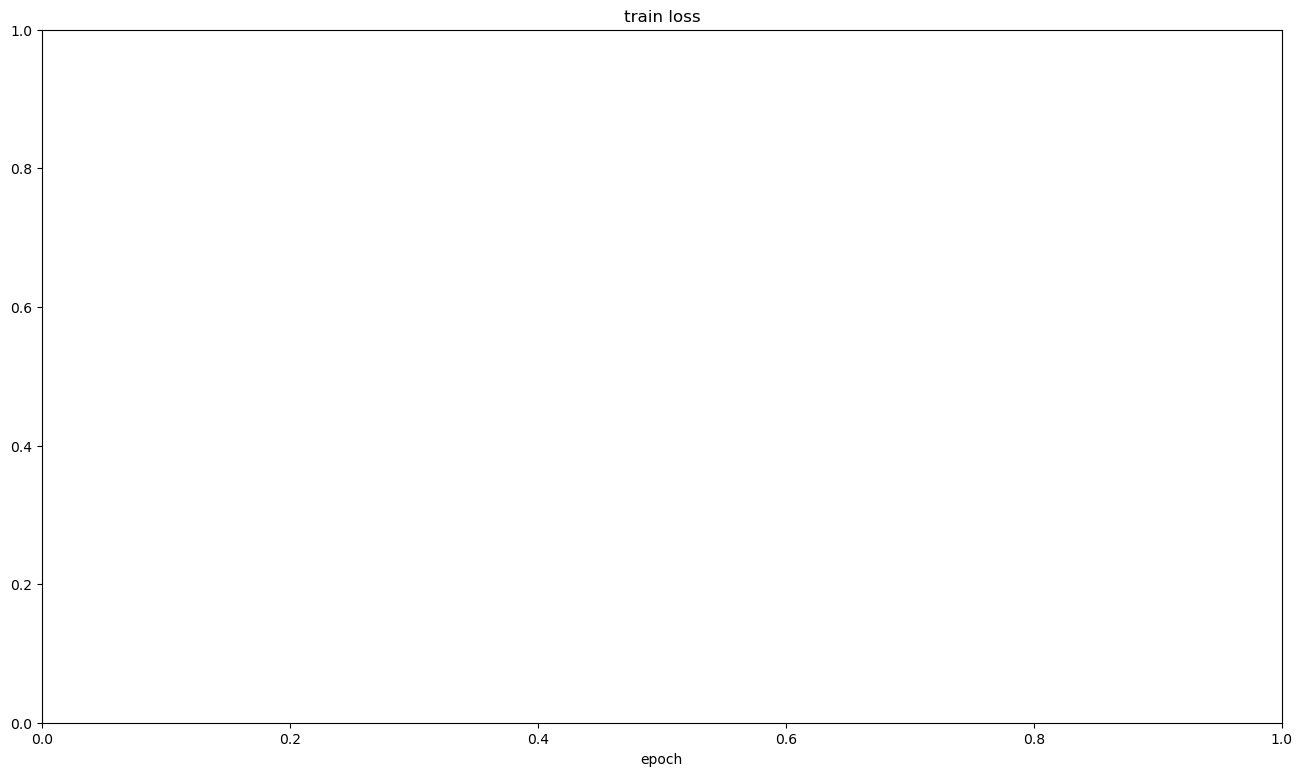

In [49]:
plt.figure(dpi=100, figsize=(16, 9))
plt.title('train loss')
plt.xlabel('epoch')
plt.plot(result['train_loss'])
None